In [20]:
from matplotlib import pyplot as plt
import pandas as pd

from dlvc.datasets.cifar10 import  CIFAR10Dataset
from dlvc.datasets.dataset import Subset
from dlvc.models.cnn import SimpleCNN, DeepCNN, DeepNormalizedCNN
from dlvc.metrics import Accuracy
import torchvision.transforms.v2 as v2
from torch import optim
import torch 
from dlvc.trainer import ImgClassificationTrainer

In [2]:
train_transform = v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
                        ])

val_transform = v2.Compose([
                        v2.ToImage(), 
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean = [0.485, 0.456,0.406], std = [0.229, 0.224, 0.225])
                        ])

# Define transformations for test set
test_transform = v2.Compose([
                        v2.ToImage(),
                        v2.ToDtype(torch.float32, scale=True),
                        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                        ])

In [3]:
train_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TRAINING, train_transform)
val_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py",Subset.VALIDATION, val_transform)
test_data = CIFAR10Dataset("data/cifar-10-python/cifar-10-batches-py", Subset.TEST, test_transform)

In [4]:
def train_model(model):
    print("Training model: ", model.__class__.__name__)
    optimizer = optim.Adam(model.parameters())
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.09)
    loss_fn = torch.nn.CrossEntropyLoss()
    train_metric = Accuracy(classes=train_data.classes)
    val_metric = Accuracy(classes=val_data.classes)
    device = torch.device("cpu")

    trainer_simple = ImgClassificationTrainer(
        model,
        optimizer,
        loss_fn,
        lr_scheduler,
        train_metric,
        val_metric,
        train_data,
        val_data,
        device,
        num_epochs = 10,
        training_save_dir="dlvc/weights/v2/" + model.__class__.__name__ + ".pt",
        batch_size=64,
        val_frequency=1
    )
    return trainer_simple

In [27]:
def test_model(model):
    print("Testing model: ", model.__class__.__name__)
    # Load test data
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
    # Load trained model
    model.load_state_dict(torch.load("dlvc/weights/v2/" + model.__class__.__name__ + ".pt"))
    model.eval()

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data.classes)

    # Define device
    device = torch.device("cpu")

    # Initialize metric for test set
    test_metric = Accuracy(classes=test_data.classes)

    # Evaluate model on test set
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            test_metric.update(output, labels)

    # Print test accuracy and per-class accuracy
    print("Test Accuracy:", test_metric.accuracy())
    print("Per-class Accuracy:", test_metric.per_class_accuracy())

    # Load existing results or create a new DataFrame
    try:
        results = pd.read_csv("results.csv")
    except FileNotFoundError:
        results = pd.DataFrame(columns=["model", "test_accuracy", "per_class_accuracy"])

    # Check if model is already in results
    if model.__class__.__name__ in results["model"].values:
        # Update results
        results.loc[results["model"] == model.__class__.__name__, "test_accuracy"] = test_metric.accuracy()
        results.loc[results["model"] == model.__class__.__name__, "per_class_accuracy"] = test_metric.per_class_accuracy()
    else:
        # Add model to results with concat
        results = pd.concat([results, pd.DataFrame([[model.__class__.__name__, test_metric.accuracy(), test_metric.per_class_accuracy()]], columns=["model", "test_accuracy", "per_class_accuracy"])], ignore_index=True)

    # Save results
    results.to_csv("results.csv", index=False)
    
    return model, test_metric

In [6]:
def plot_metrics(trainer):
    print("Plotting metrics for model: ", trainer.model.__class__.__name__)
    plt.style.use('ggplot')

    metrics = trainer.metrics_train
    metrics = list(zip(*metrics))
    loss = metrics[0]
    acc = metrics[1]
    class_acc = metrics[2]


    metrics_val = trainer.metrics_val
    metrics_val = list(zip(*metrics_val))
    loss_val = metrics_val[0]
    acc_val = metrics_val[1]
    class_acc_val = metrics_val[2]

    fig, ax = plt.subplots(1,3, figsize = (19,4))
    ax[0].plot(loss, label = "train")
    ax[0].plot(loss_val, label = "eval")
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')

    ax[1].plot(acc)
    ax[1].plot(acc_val)
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')

    ax[2].plot(class_acc)
    ax[2].plot(class_acc_val)
    ax[2].set_ylabel('Class Accuracy')
    ax[0].set_xlabel('Epoch')

    fig.legend()
    fig.suptitle("CNN training metrics")
    fig.savefig("img/v2/"+trainer.model.__class__.__name__ + ".png")

In [7]:
trainer_simple = train_model(SimpleCNN())

Training model:  SimpleCNN


In [8]:
trainer_simple.train()


TRAIN, EPOCH: 0 
Loss: 1.9992953538894653
Accuracy: 0.2309
Class Accuracy: 0.2308323547244072

VALIDATION, EPOCH: 0 
Loss: 1.9507477283477783
Accuracy: 0.3188
Class Accuracy: 0.31867616772651675
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.747403621673584
Accuracy: 0.381
Class Accuracy: 0.3810562759637833

VALIDATION, EPOCH: 1 
Loss: 1.6929935216903687
Accuracy: 0.353
Class Accuracy: 0.35333801433444023
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.1988682746887207
Accuracy: 0.3985
Class Accuracy: 0.3978093661367893

VALIDATION, EPOCH: 2 
Loss: 2.453244209289551
Accuracy: 0.3608
Class Accuracy: 0.36072627902030946
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 1.3521416187286377
Accuracy: 0.4023
Class Accuracy: 0.40217163860797883

VALIDATION, EPOCH: 3 
Loss: 1.743287444114685
Accuracy: 0.3599
C

Plotting metrics for model:  SimpleCNN


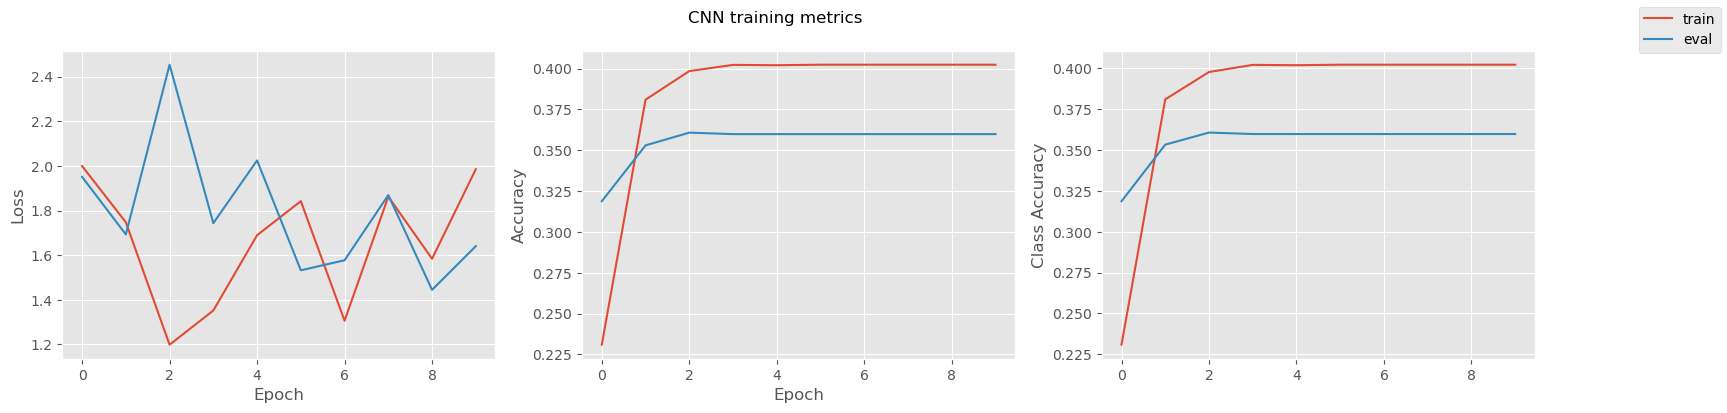

In [9]:
plot_metrics(trainer_simple)

In [28]:
model_simple, test_metric_simple = test_model(SimpleCNN())

Testing model:  SimpleCNN
Test Accuracy: 0.361
Per-class Accuracy: 0.36099999845027925


In [11]:
trainer_deep = train_model(DeepCNN())

Training model:  DeepCNN


In [12]:
trainer_deep.train()


TRAIN, EPOCH: 0 
Loss: 1.3707412481307983
Accuracy: 0.3032
Class Accuracy: 0.30332798808813094

VALIDATION, EPOCH: 0 
Loss: 1.6657744646072388
Accuracy: 0.3818
Class Accuracy: 0.3843047648668289
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.2394434213638306
Accuracy: 0.4743
Class Accuracy: 0.4740019261837006

VALIDATION, EPOCH: 1 
Loss: 1.7534583806991577
Accuracy: 0.4504
Class Accuracy: 0.45016745626926424
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.5648653507232666
Accuracy: 0.5029
Class Accuracy: 0.5027686536312104

VALIDATION, EPOCH: 2 
Loss: 1.6576530933380127
Accuracy: 0.4555
Class Accuracy: 0.4552985578775406
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 1.9159328937530518
Accuracy: 0.5048
Class Accuracy: 0.5047260582447052

VALIDATION, EPOCH: 3 
Loss: 1.7384012937545776
Accuracy: 0.456

Plotting metrics for model:  DeepCNN


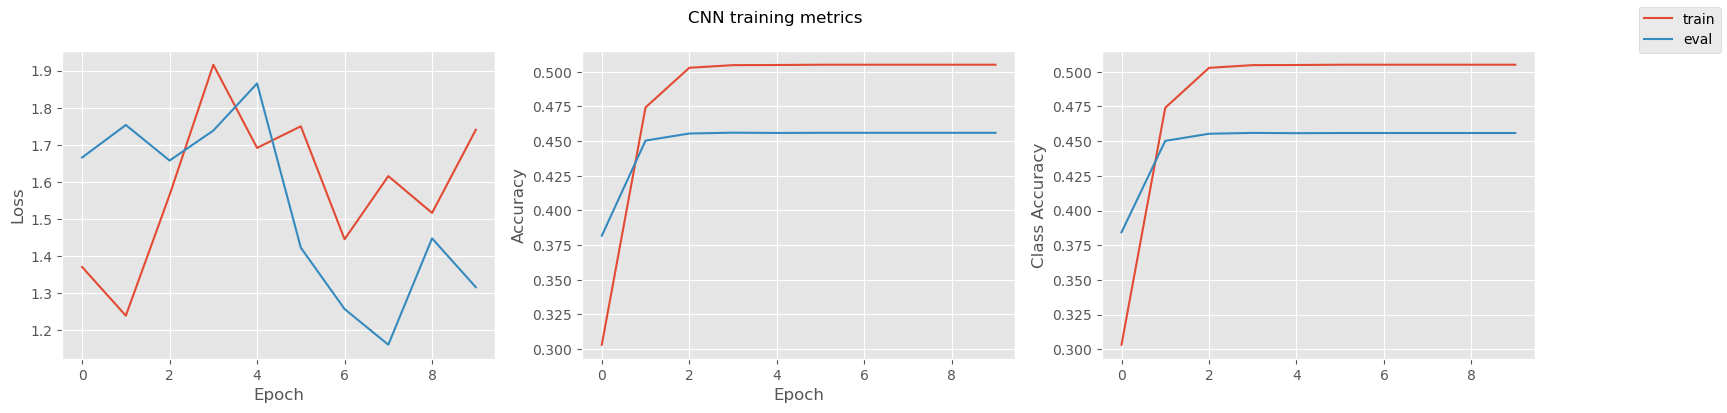

In [13]:
plot_metrics(trainer_deep)

In [29]:
model_deep, test_metric_deep = test_model(DeepCNN())

Testing model:  DeepCNN
Test Accuracy: 0.462
Per-class Accuracy: 0.4620000094175339


In [15]:
# plot metrics for test model
trainer_deep_normalized = train_model(DeepNormalizedCNN())

Training model:  DeepNormalizedCNN


In [16]:
trainer_deep_norm = train_model(DeepNormalizedCNN())

Training model:  DeepNormalizedCNN


In [17]:
trainer_deep_norm.train()


TRAIN, EPOCH: 0 
Loss: 1.338085651397705
Accuracy: 0.4009
Class Accuracy: 0.4008655518293381

VALIDATION, EPOCH: 0 
Loss: 1.6107463836669922
Accuracy: 0.3825
Class Accuracy: 0.3832546427845955
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 1 
Loss: 1.1973299980163574
Accuracy: 0.5486
Class Accuracy: 0.5484927862882614

VALIDATION, EPOCH: 1 
Loss: 1.2070109844207764
Accuracy: 0.5402
Class Accuracy: 0.5400017112493515
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 2 
Loss: 1.4643328189849854
Accuracy: 0.5743
Class Accuracy: 0.5739673018455506

VALIDATION, EPOCH: 2 
Loss: 1.3741421699523926
Accuracy: 0.5419
Class Accuracy: 0.5417251408100128
Best mean per class accuracy on validation data set is higher. Saving new best model

TRAIN, EPOCH: 3 
Loss: 1.5970211029052734
Accuracy: 0.5768
Class Accuracy: 0.5764366328716278

VALIDATION, EPOCH: 3 
Loss: 1.6743823289871216
Accuracy: 0.5411
C

Plotting metrics for model:  DeepNormalizedCNN


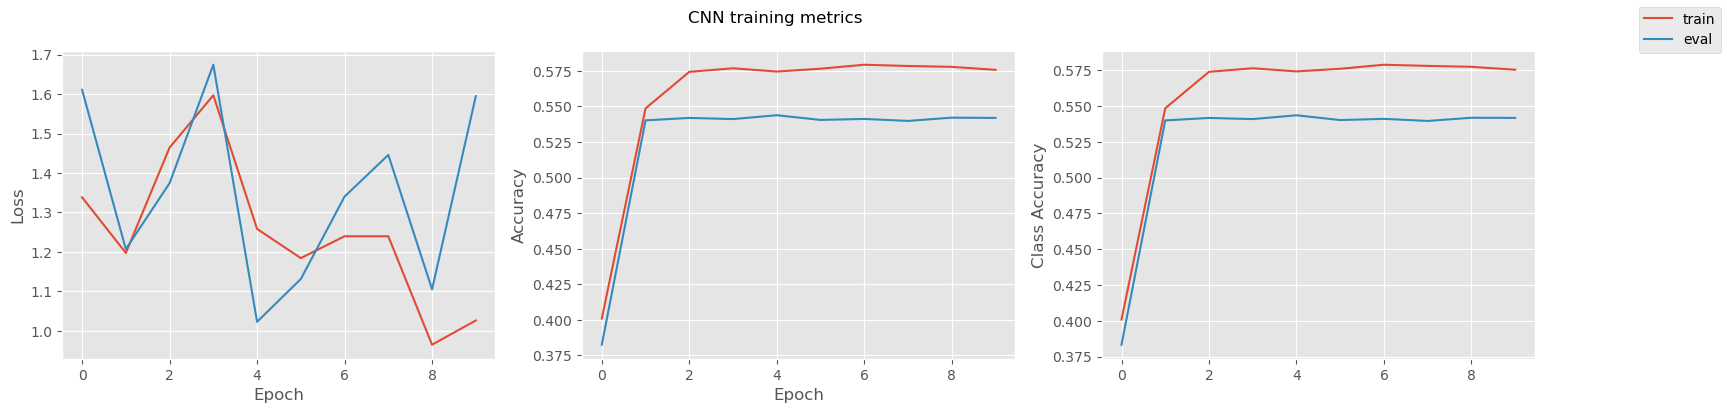

In [18]:
plot_metrics(trainer_deep_norm)

In [30]:
model_deep_norm, test_metric_deep_norm = test_model(DeepNormalizedCNN())

Testing model:  DeepNormalizedCNN
Test Accuracy: 0.539
Per-class Accuracy: 0.5390000015497207
